#### Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

I tried to run from Google drive but having issues to connect

In [9]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [10]:
import os
from pathlib import Path

In [11]:
base_dir = Path(r'C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration')
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'

In [12]:
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Train directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train
Test directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\test


In [13]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [18]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [132]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train_dir)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


### Visualize the data
##### Todo, create a code to visualize one instance of all the nine classes present in the dataset

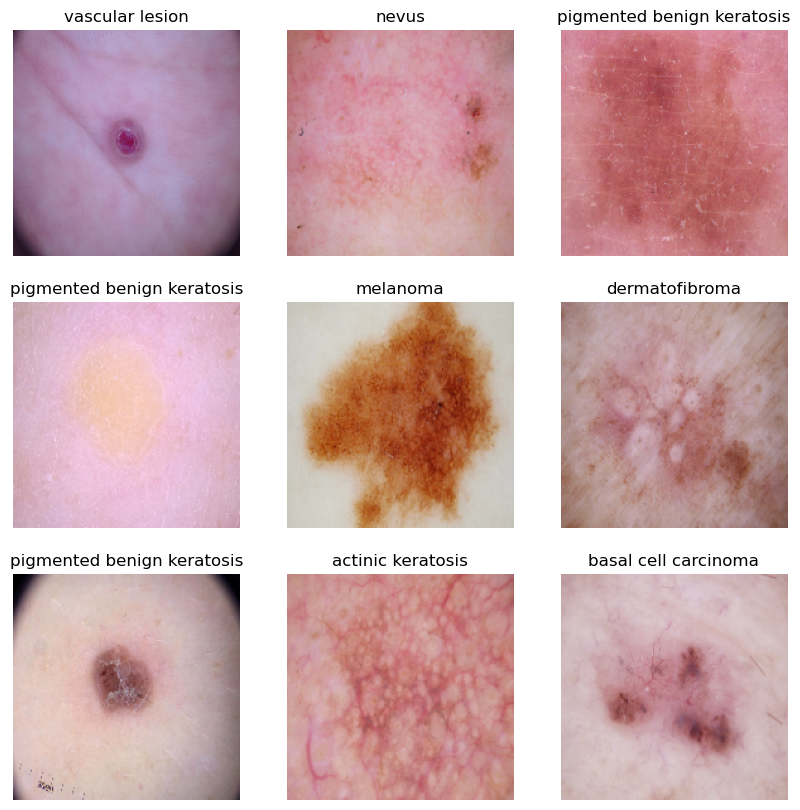

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
##### Create a CNN model, which can accurately detect 9 classes present in the dataset. 
Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. 
Here, it is good to standardize values to be in the [0, 1]

In [22]:
import tensorflow as tf

preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

C:\Users\002O5L744\AppData\Local\anaconda3\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential

input_shape = (180, 180, 3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation=activ))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation=activ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation=activ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation=activ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation=activ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))  # Number of classes is 9
model.add(layers.Activation('softmax'))  # Use 'softmax' for multi-class classification

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,793 (100.41 MB)

 Trainable params: 26,322,409 (100.41 MB)

 Non-trainable params: 384 (1.50 KB)

### Compile the model
#### Choose an appropirate optimiser and loss function for model training

In [35]:
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [36]:
# View the summary of all layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,793 (100.41 MB)

 Trainable params: 26,322,409 (100.41 MB)

 Non-trainable params: 384 (1.50 KB)

#### Train the model

In [37]:
epochs = 20
batch_size = 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2594 - loss: 2.8593 - val_accuracy: 0.1521 - val_loss: 2.2114
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.4532 - loss: 1.6143 - val_accuracy: 0.1499 - val_loss: 2.3173
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5745 - loss: 1.2310 - val_accuracy: 0.1499 - val_loss: 2.4887
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6317 - loss: 1.0984 - val_accuracy: 0.1499 - val_loss: 3.1002
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6932 - loss: 0.9069 - val_accuracy: 0.1499 - val_loss: 3.1569
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7260 - loss: 0.7990 - val_accuracy: 0.1499 - val_loss: 3.4269
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7351 - loss: 0.7195 - val_accuracy: 0.1723 - val_loss: 3.2809
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7790 - loss: 0.6303 - val_accuracy: 0.2461 - v

### Visualizing training results

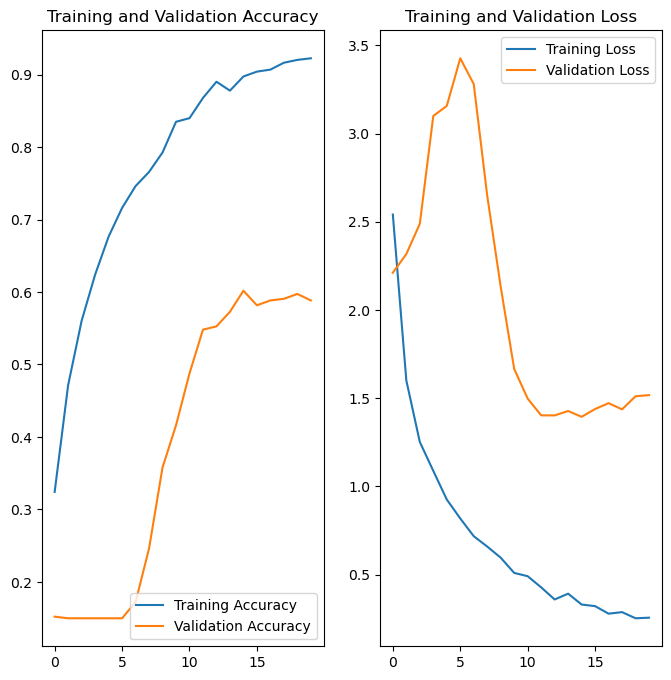

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Overfit or Underfit?

In [40]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.9394 - loss: 0.1762
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.6341 - loss: 1.4348
Accuracy:  0.9380580186843872
Validation Accuracy:  0.5883668661117554
Loss:  0.17922890186309814
Validation Loss 1.517551302909851


In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential

input_shape = (180, 180, 3)
lr = 1e-5
init = 'normal'
activ = 'relu'

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

image_class = ['nevus', 'melanoma', 'basal_cell_carcinoma', 'actinic_keratosis', 'vasc_lesion', 'dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carcinoma']

train_batches = datagen.flow_from_directory(
    train_dir, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64
)

valid_batches = datagen.flow_from_directory(
    test_dir, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


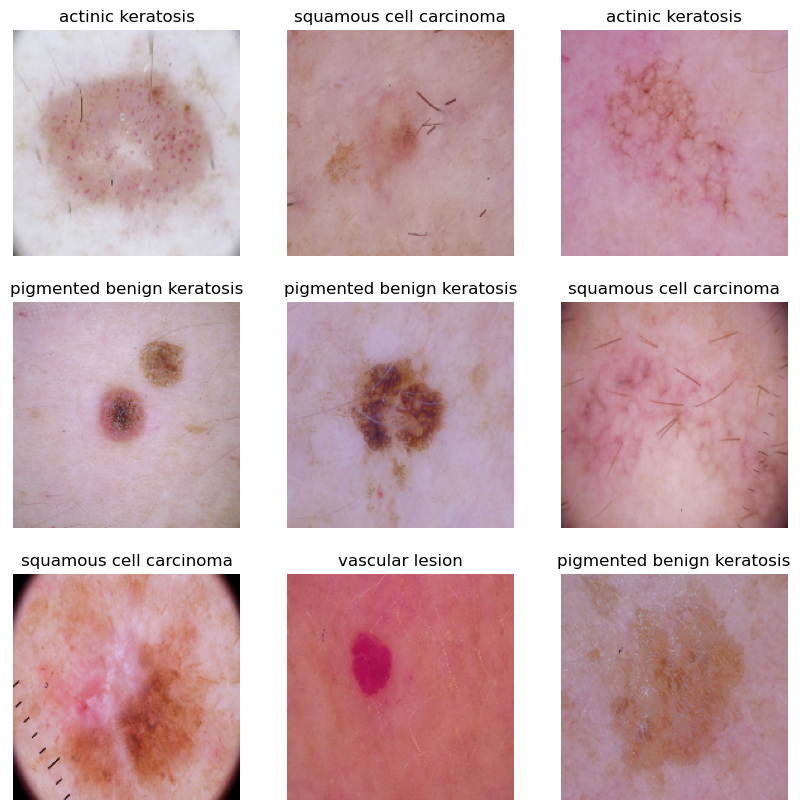

In [43]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create the model, compile and train the model

In [46]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
model = Sequential()

# Increase the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()



C:\Users\002O5L744\AppData\Local\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    28,901,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [47]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

C:\Users\002O5L744\AppData\Local\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [49]:
# Set a learning rate annealer
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [53]:
print(train_dir)
print(test_dir)

C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train
C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\test


In [54]:
train_batches = datagen.flow_from_directory(
    train_dir, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64
)

Found 890 images belonging to 9 classes.


In [55]:
valid_batches = datagen.flow_from_directory(
    test_dir, 
    target_size=(180, 180),
    classes=image_class,
    batch_size=64
)

Found 48 images belonging to 9 classes.


In [56]:
print(train_batches)
print(valid_batches)

In [57]:
train_images, train_labels = next(train_batches)
valid_images, valid_labels = next(valid_batches)

print(train_images.shape)
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)

(64, 180, 180, 3)
(64, 9)
(48, 180, 180, 3)
(48, 9)


In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel   


def train_generator():
    for images, labels in datagen.flow_from_directory(
        'train_data',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Adjust based on your classification problem
    ):
        yield images, labels


In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [69]:
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs, verbose=1)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.3398 - loss: 400.8906 - val_accuracy: 0.3333 - val_loss: 1.6841
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.4341 - loss: 1.8605 - val_accuracy: 0.3333 - val_loss: 1.8699
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.4829 - loss: 1.0582 - val_accuracy: 0.2708 - val_loss: 1.7984
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.4942 - loss: 0.9716 - val_accuracy: 0.3125 - val_loss: 1.7014
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.4970 - loss: 0.9397 - val_accuracy: 0.3125 - val_loss: 1.7870
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.5538 - loss: 0.8893 - val_accuracy: 0.4792 - val_loss: 1.6592
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.6008 - loss: 0.8537 - val_accuracy: 0.4167 - val_loss: 1.6808
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.6121 - loss: 0.8150 - val_accuracy: 0.4792 - val

<built-in method keys of dict object at 0x0000013F43A66780> :


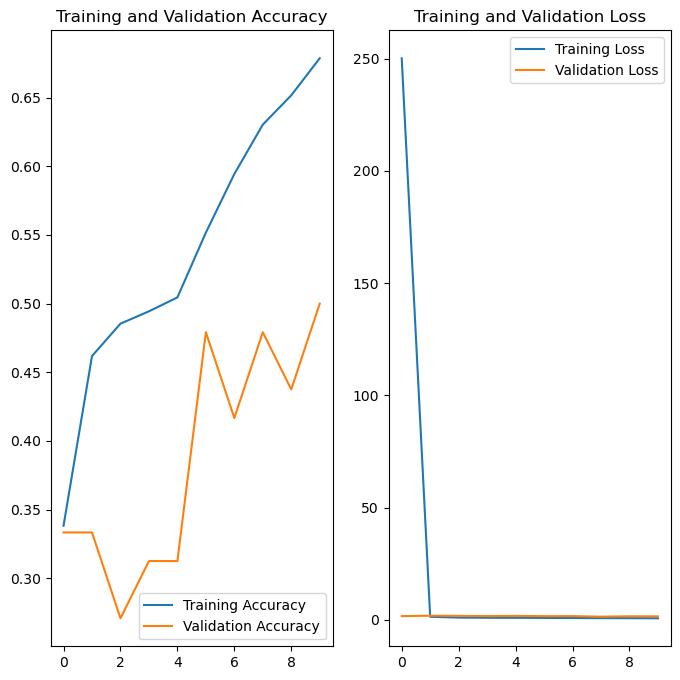

In [70]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 1000x1000 with 0 Axes>

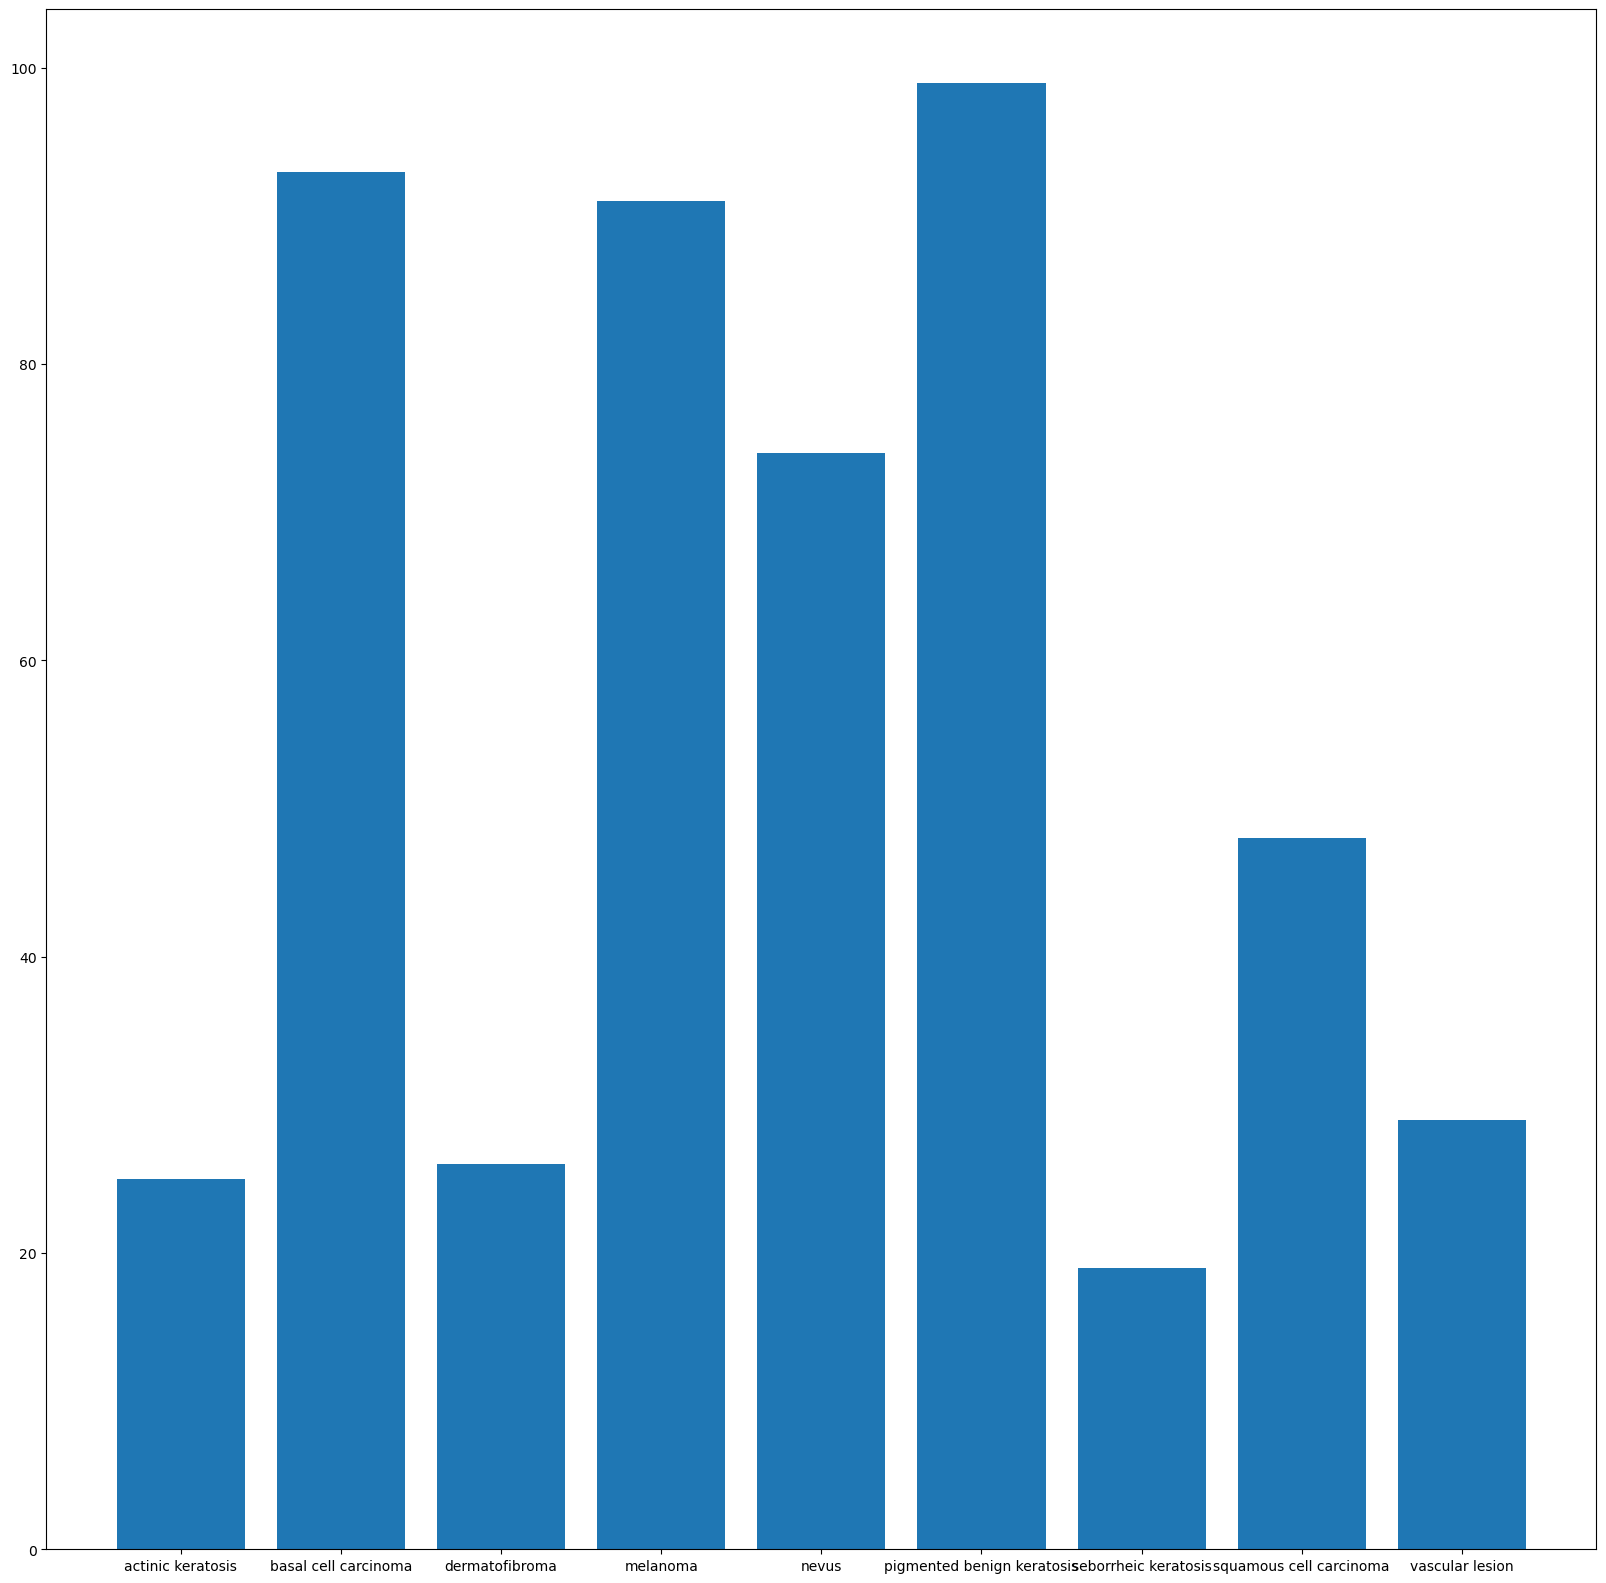

In [72]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

- Which class has the least number of samples? - Actinic Keratosos and Seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training

In [75]:
path_to_training_dataset = "C:/Users/002O5L744/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train"

base_path = Path(r"C:/Users/002O5L744/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train")

class_names = [d.name for d in base_path.iterdir() if d.is_dir()]

print(f"Class names: {class_names}")

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [76]:
import Augmentor
for class_name in class_names:
    class_path = base_path / class_name
    print(f"Processing class directory: {class_path}")
    if class_path.exists():
        p = Augmentor.Pipeline(str(class_path))  # Convert Path object to string if necessary
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)
    else:
        print(f"Directory does not exist: {class_path}")

Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\actinic keratosis
Initialised with 114 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13F3DC936D0>: 100%|██████████| 500/500 [00:06<00:00, 76.38 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13F3DCCDED0>: 100%|██████████| 500/500 [00:10<00:00, 48.96 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\dermatofibroma
Initialised with 95 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13F382AF040>: 100%|██████████| 500/500 [00:10<00:00, 49.72 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\melanoma
Initialised with 438 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x13F3DD03940>: 100%|██████████| 500/500 [00:54<00:00,  9.11 Samples/s] 


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\nevus
Initialised with 357 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2725x2082 at 0x13E250CC1F0>: 100%|██████████| 500/500 [00:39<00:00, 12.50 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13F37FF7BE0>: 100%|██████████| 500/500 [00:09<00:00, 54.88 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x13F3DCBD570>: 100%|██████████| 500/500 [00:20<00:00, 24.25 Samples/s]                  


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x13F37FF8310>: 100%|██████████| 500/500 [00:09<00:00, 52.88 Samples/s]


Processing class directory: C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\vascular lesion
Initialised with 139 image(s) found.
Output directory set to C:\Users\002O5L744\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13E25F25E70>: 100%|██████████| 500/500 [00:09<00:00, 52.02 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [77]:
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [87]:
import glob
import os

# Construct the pattern for glob
pattern = os.path.join(train_dir, '*', 'output', '*.jpg')

# Get the list of files matching the pattern
path_list = [x for x in glob.glob(pattern)]

print(path_list)


['C:\\Users\\002O5L744\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b6fe31e1-ad53-4035-8592-01e4d967086f.jpg', 'C:\\Users\\002O5L744\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d289ff5e-0168-4e4e-a0eb-cd26e0a75891.jpg', 'C:\\Users\\002O5L744\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_18c47141-cbb0-4e1e-a4cf-bb1d824c131e.jpg', 'C:\\Users\\002O5L744\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1e6fc6a9-760f-4468-b07e-516d4c213f7e.jpg', 'C:\\Users\\002O5L744\\Downloads\\CNN_assignment\\Skin cancer I

In [88]:
import glob
import os

dataframe_dict_new = dict(zip(path_list, lesion_list_new))



In [89]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [90]:
new_df['Label'].value_counts()

label1    1
label2    1
label3    1
Name: Label, dtype: int64

### Train the model on the data created using Augmentor

In [92]:
batch_size = 32
img_height = 180
img_width = 180

In [93]:
data_dir_train="C:/Users/002O5L744/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [94]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (180, 180, 3)
model = Sequential()

# First block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Third block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

### Compile your model (Choose optimizer and loss function appropriately)

In [122]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,867,305 (121.56 MB)

 Trainable params: 31,865,641 (121.56 MB)

 Non-trainable params: 1,664 (6.50 KB)

## Train your model

In [124]:
# Create the data generators
train_dir = "C:/Users/002O5L744/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train"
test_dir = "C:/Users/002O5L744/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/test"

In [125]:
datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    rotation_range=10, 
    zoom_range=0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=False, 
    vertical_flip=False
)

In [126]:
image_class = ['nevus', 'melanoma', 'basal_cell_carcinoma', 'actinic_keratosis', 'vasc_lesion', 'dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carcinoma']
train_batches = datagen.flow_from_directory(train_dir, 
                                            target_size=(180, 180),
                                            classes=image_class,
                                            batch_size=64,
                                            class_mode='categorical')

valid_batches = datagen.flow_from_directory(test_dir, 
                                            target_size=(180, 180),
                                            classes=image_class,
                                            batch_size=64,
                                            class_mode='categorical')

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


In [127]:
# Verify that the data generators are properly created
print(f"Training batches: {len(train_batches)}")
print(f"Validation batches: {len(valid_batches)}")


Training batches: 38
Validation batches: 1


In [128]:
# Print batch shapes
for data_batch, labels_batch in train_batches:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

Data batch shape: (64, 180, 180, 3)
Labels batch shape: (64, 9)


In [129]:
# Define the ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [130]:
# Train the model
epochs = 40
batch_size = 10

history = model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs,
  verbose=1,
  callbacks=[learning_rate_reduction]
)


Epoch 1/40


C:\Users\002O5L744\AppData\Local\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 347s 9s/step - accuracy: 0.4518 - loss: 2.2019 - val_accuracy: 0.2500 - val_loss: 2.4188 - learning_rate: 1.0000e-04
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.6748 - loss: 1.4252 - val_accuracy: 0.4583 - val_loss: 1.8971 - learning_rate: 1.0000e-04
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 313s 8s/step - accuracy: 0.7185 - loss: 1.1384 - val_accuracy: 0.6458 - val_loss: 2.4435 - learning_rate: 1.0000e-04
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.7321 - loss: 1.0550 - val_accuracy: 0.5417 - val_loss: 3.0939 - learning_rate: 1.0000e-04
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 301s 8s/step - accuracy: 0.7437 - loss: 0.9396 - val_accuracy: 0.5208 - val_loss: 4.3829 - learning_rate: 1.0000e-04
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7436 - loss: 0.8852
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
38/38 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.7441 - loss: 0.8846 - v

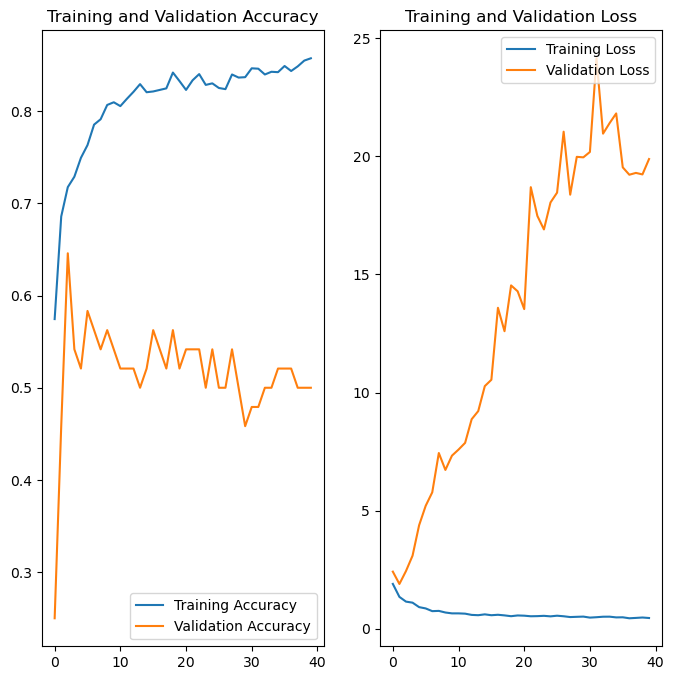

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Did you get rid of underfitting/overfitting? Did class rebalance help?

The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward